=== What we ran ===
Experiment(s): FL_GAN_Attack_Demo
Models: BiLSTM, SoftDenseMoE, SoftLSTMMoE
Attack type(s): poison
Attack details (sample): mode=noise, distribution=uniform, scale=0.2
Attack label(s): poison(mode=noise, distribution=uniform, scale=0.2)
Clusters: 2 | Avg cluster size: 2.00 | Total buildings seen: 4
Rounds (replicates): 3 | Fed rounds (communication): 3
Poisoned building per cluster (by design = first in each cluster):
cluster_id  poisoned_building
       C01                  4
       C02                  2

=== Aggregated (overall, by architecture) ===
architecture  mse_mean  mse_std  rmse_mean  rmse_std  mae_mean  mae_std  train_time_mean  train_time_std  avg_epoch_time_mean  avg_epoch_time_std
      BiLSTM  0.015487 0.005872   0.121791  0.025932  0.077295 0.023350        42.954002        3.691470            20.892547            1.810441
SoftDenseMoE  0.013309 0.005898   0.112015  0.027995  0.066787 0.024777         6.118471        0.319288             2.969034    

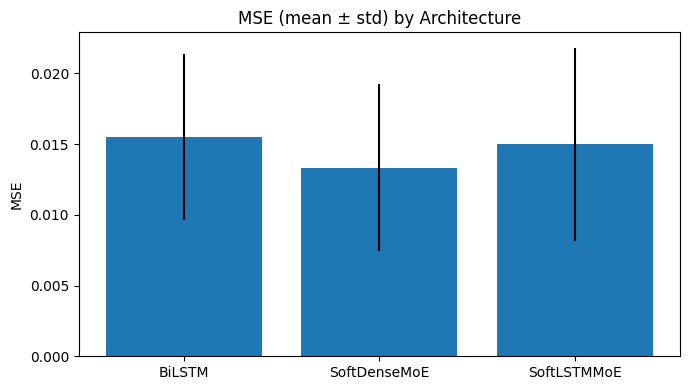

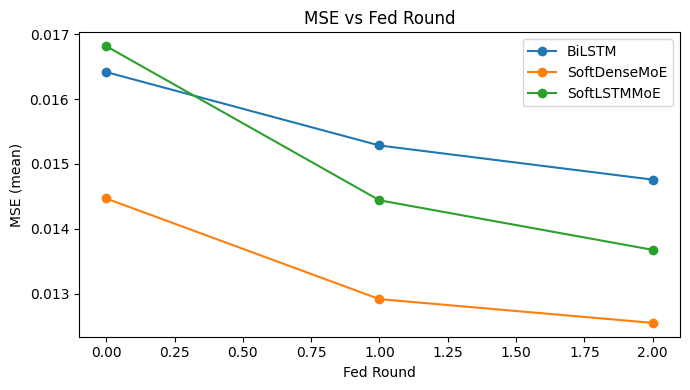

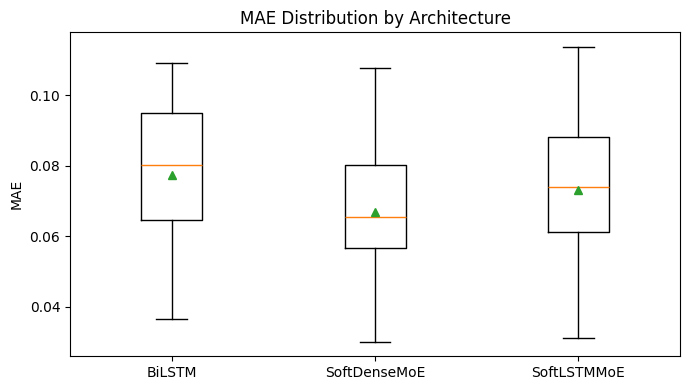

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def analyze_fl_results(csv_path, save_figs=True):
    """
    Prints summary ("what we did"), prints aggregated results, and shows plots.
    If per-hour results file exists (for backdoor), it will also summarize and plot per-hour metrics.
    """
    # -----------------------
    # Load main results
    # -----------------------
    df = pd.read_csv(csv_path)
    if df.empty:
        print("No rows in results file.")
        return None

    # Optional figure directory
    fig_dir = os.path.join(os.path.dirname(csv_path), "analysis_figs")
    if save_figs:
        os.makedirs(fig_dir, exist_ok=True)

    # -----------------------
    # 1) Print what we did
    # -----------------------
    exp_names = sorted(df["experiment"].dropna().unique().tolist())
    archs = sorted(df["architecture"].dropna().unique().tolist())
    attacks = sorted(df["attack"].dropna().unique().tolist())
    attack_types = sorted(df["attack_type"].dropna().unique().tolist())
    attack_details = sorted(df["attack_details"].dropna().unique().tolist())

    n_clusters = df["cluster_id"].nunique()
    cluster_sizes = df.groupby("cluster_id")["building"].nunique()
    buildings_total = df["building"].nunique()
    rounds = int(df["round"].max()) + 1 if df["round"].notna().any() else 0
    fed_rounds = int(df["fed_round"].max()) + 1 if df["fed_round"].notna().any() else 0
    poisoned_info = (df[["cluster_id","poisoned_building"]]
                     .drop_duplicates()
                     .sort_values("cluster_id"))
    
    print("=== What we ran ===")
    print(f"Experiment(s): {', '.join(exp_names)}")
    print(f"Models: {', '.join(archs)}")
    print(f"Attack type(s): {', '.join(attack_types) if attack_types else 'n/a'}")
    if attack_details:
        # Keep this readable if many unique combos appear
        shown = attack_details[:5]
        more = f" (+{len(attack_details)-5} more)" if len(attack_details) > 5 else ""
        print(f"Attack details (sample): {', '.join(shown)}{more}")
    print(f"Attack label(s): {', '.join(attacks)}")
    print(f"Clusters: {n_clusters} | Avg cluster size: {cluster_sizes.mean():.2f} | Total buildings seen: {buildings_total}")
    print(f"Rounds (replicates): {rounds} | Fed rounds (communication): {fed_rounds}")
    print("Poisoned building per cluster (by design = first in each cluster):")
    print(poisoned_info.to_string(index=False))
    print()

    # -----------------------
    # 2) Aggregated results
    # -----------------------
    overall = (df.groupby("architecture")
                 .agg(
                     mse_mean=("mse","mean"),
                     mse_std =("mse","std"),
                     rmse_mean=("rmse","mean"),
                     rmse_std =("rmse","std"),
                     mae_mean=("mae","mean"),
                     mae_std =("mae","std"),
                     train_time_mean=("train_time","mean"),
                     train_time_std =("train_time","std"),
                     avg_epoch_time_mean=("avg_time_epoch","mean"),
                     avg_epoch_time_std =("avg_time_epoch","std")
                 )
                 .reset_index())

    print("=== Aggregated (overall, by architecture) ===")
    print(overall.to_string(index=False))
    print()

    # Aggregation: MSE vs Fed round (averaged across users & outer rounds)
    mse_by_fed = (df.groupby(["architecture","fed_round"])["mse"]
                    .mean()
                    .reset_index()
                    .sort_values(["architecture","fed_round"]))

    print("=== MSE by Fed round (mean across users & outer rounds) ===")
    print(mse_by_fed.to_string(index=False))
    print()

    # -----------------------
    # 3) Plots
    # -----------------------
    # 3a) Bar: MSE mean (+/- std) per architecture
    plt.figure(figsize=(7,4))
    x = np.arange(len(overall))
    y = overall["mse_mean"].values
    yerr = overall["mse_std"].values
    plt.bar(x, y, yerr=yerr)
    plt.xticks(x, overall["architecture"].tolist(), rotation=0)
    plt.ylabel("MSE")
    plt.title("MSE (mean ± std) by Architecture")
    plt.tight_layout()
    if save_figs:
        plt.savefig(os.path.join(fig_dir, "mse_by_architecture.png"), dpi=150, bbox_inches="tight")
    plt.show()

    # 3b) Line: MSE vs Fed round for each architecture
    plt.figure(figsize=(7,4))
    for arch in mse_by_fed["architecture"].unique():
        sub = mse_by_fed[mse_by_fed["architecture"] == arch]
        plt.plot(sub["fed_round"].values, sub["mse"].values, marker="o", label=arch)
    plt.xlabel("Fed Round")
    plt.ylabel("MSE (mean)")
    plt.title("MSE vs Fed Round")
    plt.legend()
    plt.tight_layout()
    if save_figs:
        plt.savefig(os.path.join(fig_dir, "mse_vs_fed_round.png"), dpi=150, bbox_inches="tight")
    plt.show()

    # 3c) Boxplot: MAE distribution by architecture
    plt.figure(figsize=(7,4))
    data = [df[df["architecture"]==arch]["mae"].values for arch in archs]
    plt.boxplot(data, labels=archs, showmeans=True)
    plt.ylabel("MAE")
    plt.title("MAE Distribution by Architecture")
    plt.tight_layout()
    if save_figs:
        plt.savefig(os.path.join(fig_dir, "mae_boxplot_by_architecture.png"), dpi=150, bbox_inches="tight")
    plt.show()

    # -----------------------
    # Optional: Per-hour results (for backdoor runs)
    # -----------------------
    # We look for a sibling per-hour CSV:
    #   ...__ALL_CLUSTERS__per_hour_results.csv
    per_hour_path = csv_path.replace("__all_results.csv", "__per_hour_results.csv").replace("__ALL_CLUSTERS__all_results", "__ALL_CLUSTERS__per_hour_results")
    if os.path.exists(per_hour_path):
        ph = pd.read_csv(per_hour_path)
        if not ph.empty:
            print("=== Per-hour results detected (backdoor) ===")
            # Aggregate per-hour by architecture
            ph_agg = (ph.groupby(["architecture","hour"])
                        .agg(mse_mean=("mse","mean"),
                             mse_std =("mse","std"),
                             rmse_mean=("rmse","mean"),
                             mae_mean=("mae","mean"))
                        .reset_index())
            print(ph_agg.head().to_string(index=False))
            print()

            # Line plot: per-hour MSE (mean) by architecture
            # (one figure, multiple lines)
            plt.figure(figsize=(8,4))
            for arch in ph_agg["architecture"].unique():
                sub = ph_agg[ph_agg["architecture"]==arch].sort_values("hour")
                plt.plot(sub["hour"].values, sub["mse_mean"].values, marker="o", label=arch)
            plt.xlabel("Hour of Day")
            plt.ylabel("MSE (mean)")
            plt.title("Per-hour MSE (mean) by Architecture")
            plt.xticks(range(0,24,2))
            plt.legend()
            plt.tight_layout()
            if save_figs:
                plt.savefig(os.path.join(fig_dir, "per_hour_mse_mean.png"), dpi=150, bbox_inches="tight")
            plt.show()

            # Heatmap-style imshow: hour x architecture (MSE mean)
            # (no seaborn; basic imshow)
            pivot = ph_agg.pivot(index="hour", columns="architecture", values="mse_mean").sort_index()
            plt.figure(figsize=(6,4))
            plt.imshow(pivot.values, aspect="auto")
            plt.yticks(ticks=np.arange(pivot.shape[0]), labels=pivot.index)
            plt.xticks(ticks=np.arange(pivot.shape[1]), labels=pivot.columns, rotation=45)
            plt.xlabel("Architecture")
            plt.ylabel("Hour")
            plt.title("Per-hour MSE (mean) — heatmap")
            plt.tight_layout()
            if save_figs:
                plt.savefig(os.path.join(fig_dir, "per_hour_mse_heatmap.png"), dpi=150, bbox_inches="tight")
            plt.show()
        else:
            print("Per-hour file exists but is empty.")
    else:
        # It’s fine—per-hour is only produced for backdoor runs
        pass

    return {
        "overall": overall,
        "mse_by_fed": mse_by_fed
    }

# --- Use it:
csv_path = r"results2\FL_GAN_Attack_Demo__ALL_CLUSTERS__all_results.csv"
summary = analyze_fl_results(csv_path, save_figs=False)



What we ran
Experiment(s): FL_GAN_Attack_Demo
Models: BiLSTM, SoftDenseMoE, SoftLSTMMoE
Attack label(s): poison(mode=noise, distribution=uniform, scale=0.2)
Clusters: 2 | Rounds: 3 | Fed rounds: 3
Comparison mode: WITHIN-RUN poisoned (user1) vs bystanders (non-poisoned)

Within-run: poisoned building vs bystanders (same attacked run)
architecture  is_poisoned_building  mse_mean  mse_std  rmse_mean  mae_mean  n
      BiLSTM                 False  0.014377 0.008189   0.114824  0.073941 18
      BiLSTM                  True  0.016597 0.001148   0.128757  0.080648 18
SoftDenseMoE                 False  0.012738 0.008344   0.106309  0.067597 18
SoftDenseMoE                  True  0.013881 0.001146   0.117721  0.065976 18
 SoftLSTMMoE                 False  0.014659 0.009704   0.113868  0.072491 18
 SoftLSTMMoE                  True  0.015295 0.001241   0.123579  0.073982 18

Effect (MSE):
architecture  mse_clean_like  mse_poisoned    delta       pct
      BiLSTM        0.014377      0.0165

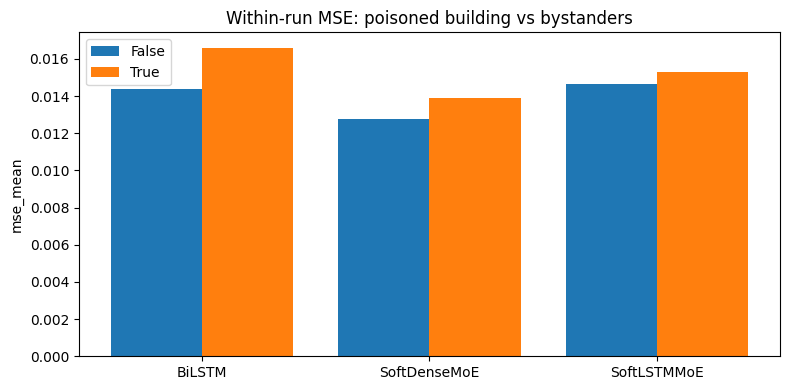

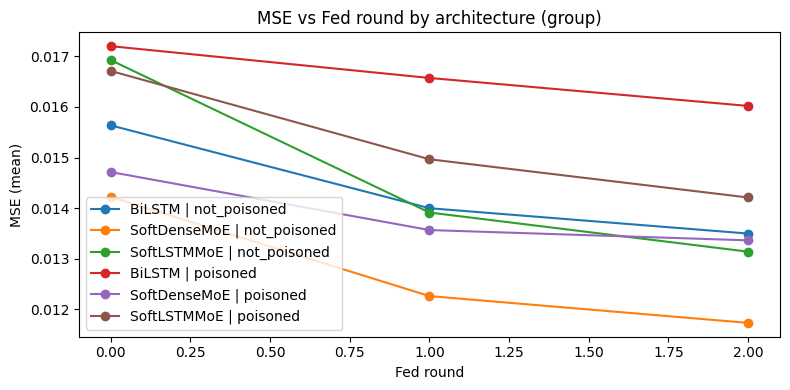

In [3]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def _safe_mean_std(df, value_col, by):
    agg = (df.groupby(by)[value_col]
             .agg(['mean','std','count'])
             .reset_index()
             .rename(columns={'mean': f'{value_col}_mean', 'std': f'{value_col}_std', 'count': f'{value_col}_n'}))
    return agg

def _print_section(title):
    print("\n" + "="*len(title))
    print(title)
    print("="*len(title))

def _attach_source(df, label):
    df = df.copy()
    df['source'] = label
    return df

def _load_results(csv_path_attack, csv_path_clean=None):
    att = pd.read_csv(csv_path_attack)
    if csv_path_clean and os.path.exists(csv_path_clean):
        cln = pd.read_csv(csv_path_clean)
        return _attach_source(att, 'attack'), _attach_source(cln, 'clean')
    return _attach_source(att, 'attack'), None

def _mark_poisoned_within_run(df):
    """
    Within a single run, rows for the poisoned building are where:
    - attack_type != 'none' AND
    - building == poisoned_building (by design that's user1)
    Everything else in that run is considered 'not_poisoned' (bystanders).
    """
    df = df.copy()
    df['is_poisoned_building'] = (df['attack_type'].fillna('none')!='none') & (df['building']==df['poisoned_building'])
    return df

def _summarize_context(df_attack, df_clean):
    _print_section("What we ran")
    exps = ", ".join(sorted(df_attack['experiment'].dropna().unique()))
    archs = ", ".join(sorted(df_attack['architecture'].dropna().unique()))
    attacks = ", ".join(sorted(df_attack['attack'].dropna().unique()))
    n_clusters = df_attack['cluster_id'].nunique()
    rounds = int(df_attack['round'].max())+1 if df_attack['round'].notna().any() else 0
    freds  = int(df_attack['fed_round'].max())+1 if df_attack['fed_round'].notna().any() else 0

    print(f"Experiment(s): {exps}")
    print(f"Models: {archs}")
    print(f"Attack label(s): {attacks}")
    print(f"Clusters: {n_clusters} | Rounds: {rounds} | Fed rounds: {freds}")
    if df_clean is not None:
        print("Comparison mode: CLEAN (baseline) vs ATTACK (poison/backdoor).")
    else:
        print("Comparison mode: WITHIN-RUN poisoned (user1) vs bystanders (non-poisoned)")

def _aggregate_within_run(df_attack):
    # mark poisoned vs not
    dfw = _mark_poisoned_within_run(df_attack)
    # aggregate by architecture & poisoned flag
    overall = (dfw
               .groupby(['architecture','is_poisoned_building'])
               .agg(mse_mean=('mse','mean'),
                    mse_std =('mse','std'),
                    rmse_mean=('rmse','mean'),
                    mae_mean=('mae','mean'),
                    n=('mse','count'))
               .reset_index())
    # effect (poisoned - not_poisoned) per architecture
    effect = (overall
              .pivot(index='architecture', columns='is_poisoned_building', values='mse_mean')
              .rename(columns={False:'mse_clean_like', True:'mse_poisoned'})
              .assign(delta=lambda d: d['mse_poisoned']-d['mse_clean_like'],
                      pct=lambda d: 100*(d['mse_poisoned']-d['mse_clean_like'])/d['mse_clean_like'])
              .reset_index())
    return dfw, overall, effect

def _aggregate_cross_runs(df_attack, df_clean):
    # compare attack vs clean per architecture
    both = pd.concat([df_attack, df_clean], ignore_index=True)
    overall = (both
               .groupby(['architecture','source'])
               .agg(mse_mean=('mse','mean'),
                    mse_std =('mse','std'),
                    rmse_mean=('rmse','mean'),
                    mae_mean=('mae','mean'),
                    n=('mse','count'))
               .reset_index())

    effect = (overall
              .pivot(index='architecture', columns='source', values='mse_mean')
              .rename(columns={'clean':'mse_clean', 'attack':'mse_attack'})
              .assign(delta=lambda d: d['mse_attack']-d['mse_clean'],
                      pct=lambda d: 100*(d['mse_attack']-d['mse_clean'])/d['mse_clean'])
              .reset_index())
    return both, overall, effect

def _plot_bar_group(df, x_col, y_col, hue_col, title, save_path=None):
    # Simple grouped bar without seaborn
    groups = df[hue_col].unique().tolist()
    cats = df[x_col].unique().tolist()
    idx = np.arange(len(cats))
    width = 0.8 / max(len(groups),1)

    plt.figure(figsize=(8,4))
    for gi, g in enumerate(groups):
        sub = df[df[hue_col]==g].set_index(x_col).reindex(cats)
        plt.bar(idx + gi*width, sub[y_col].values, width=width, label=str(g))
    plt.xticks(idx + (len(groups)-1)*width/2, cats, rotation=0)
    plt.ylabel(y_col)
    plt.title(title)
    plt.legend()
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches="tight")
    plt.show()

def _plot_mse_vs_fed(df, group_label, save_path=None):
    plt.figure(figsize=(8,4))
    for grp in sorted(df[group_label].dropna().unique()):
        sub = (df[df[group_label]==grp]
               .groupby(['architecture','fed_round'])['mse']
               .mean().reset_index())
        for arch in sub['architecture'].unique():
            s = sub[sub['architecture']==arch]
            plt.plot(s['fed_round'].values, s['mse'].values, marker='o', label=f"{arch} | {grp}")
    plt.xlabel("Fed round")
    plt.ylabel("MSE (mean)")
    plt.title(f"MSE vs Fed round by architecture ({group_label})")
    plt.legend()
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches="tight")
    plt.show()

def _load_per_hour(csv_path_all):
    ph = csv_path_all.replace("__ALL_CLUSTERS__all_results.csv", "__ALL_CLUSTERS__per_hour_results.csv")
    return pd.read_csv(ph) if os.path.exists(ph) else None

def _prep_per_hour_flags(ph_df_attack):
    # in per-hour CSV we kept "user" (e.g., user1). user1 is the poisoned building in each cluster.
    ph = ph_df_attack.copy()
    ph['is_poisoned_building'] = ph['user'].astype(str).str.lower().eq('user1')
    return ph

def analyze_poison_vs_not(
    csv_path_attack,
    csv_path_clean=None,
    save_figs=True
):
    """
    Focused on the effect of poisoned vs not-poisoned.
    - If csv_path_clean is given, compares CLEAN vs ATTACK across runs.
    - Always compares poisoned building (user1) vs others within the ATTACK run.
    - If per-hour files exist (backdoor), computes per-hour gaps too.
    """
    out_dir = os.path.join(os.path.dirname(csv_path_attack), "analysis_poison_vs_not")
    if save_figs:
        os.makedirs(out_dir, exist_ok=True)

    df_attack, df_clean = _load_results(csv_path_attack, csv_path_clean)
    _summarize_context(df_attack, df_clean)

    # -------- within-run (attack): poisoned building vs bystanders
    dfw, within_overall, within_effect = _aggregate_within_run(df_attack)
    _print_section("Within-run: poisoned building vs bystanders (same attacked run)")
    print(within_overall.to_string(index=False))
    print("\nEffect (MSE):")
    print(within_effect.to_string(index=False))

    # plots (within-run)
    _plot_bar_group(
        df=within_overall.rename(columns={'is_poisoned_building':'group'}),
        x_col='architecture', y_col='mse_mean', hue_col='group',
        title='Within-run MSE: poisoned building vs bystanders',
        save_path=os.path.join(out_dir, "within_run_mse_bar.png") if save_figs else None
    )

    _plot_mse_vs_fed(
        df=dfw.assign(group=np.where(dfw['is_poisoned_building'], 'poisoned','not_poisoned')),
        group_label='group',
        save_path=os.path.join(out_dir, "within_run_mse_vs_fed.png") if save_figs else None
    )

    # -------- cross-run (optional): clean vs attack
    if df_clean is not None:
        both, cross_overall, cross_effect = _aggregate_cross_runs(df_attack, df_clean)
        _print_section("Cross-run: CLEAN (baseline) vs ATTACK (all buildings pooled)")
        print(cross_overall.to_string(index=False))
        print("\nEffect (MSE):")
        print(cross_effect.to_string(index=False))

        _plot_bar_group(
            df=cross_overall.rename(columns={'source':'group'}),
            x_col='architecture', y_col='mse_mean', hue_col='group',
            title='Cross-run MSE: CLEAN vs ATTACK',
            save_path=os.path.join(out_dir, "cross_run_mse_bar.png") if save_figs else None
        )

        _plot_mse_vs_fed(
            df=both.rename(columns={'source':'group'}),
            group_label='group',
            save_path=os.path.join(out_dir, "cross_run_mse_vs_fed.png") if save_figs else None
        )

    # -------- per-hour (backdoor runs)
    ph_attack = _load_per_hour(csv_path_attack)
    if ph_attack is not None and not ph_attack.empty:
        _print_section("Per-hour (attack run): poisoned vs bystanders")
        phA = _prep_per_hour_flags(ph_attack)
        # aggregate per-hour by arch & poisoned flag
        phA_overall = (phA
                       .groupby(['architecture','is_poisoned_building','hour'])
                       .agg(mse_mean=('mse','mean'),
                            rmse_mean=('rmse','mean'),
                            mae_mean=('mae','mean'))
                       .reset_index())
        print(phA_overall.head().to_string(index=False))

        # line plot per-hour MSE (poisoned vs not) per architecture
        for arch in phA_overall['architecture'].unique():
            sub = phA_overall[phA_overall['architecture']==arch]
            plt.figure(figsize=(8,4))
            for grp in [False, True]:
                s = sub[sub['is_poisoned_building']==grp].sort_values('hour')
                label = 'poisoned' if grp else 'not_poisoned'
                plt.plot(s['hour'].values, s['mse_mean'].values, marker='o', label=label)
            plt.title(f"Per-hour MSE (attack run) — {arch}")
            plt.xlabel("Hour")
            plt.ylabel("MSE (mean)")
            plt.xticks(range(0,24,2))
            plt.legend()
            plt.tight_layout()
            if save_figs:
                plt.savefig(os.path.join(out_dir, f"per_hour_mse_{arch}.png"), dpi=150, bbox_inches="tight")
            plt.show()

    # If a clean per-hour file exists too, compare clean vs attack per-hour (pooled across users)
    if csv_path_clean:
        ph_clean = _load_per_hour(csv_path_clean)
        if ph_clean is not None and not ph_clean.empty and ph_attack is not None and not ph_attack.empty:
            _print_section("Per-hour (cross-run): CLEAN vs ATTACK (pooled)")
            # mean per-hour per arch
            A = (ph_attack.groupby(['architecture','hour'])['mse'].mean().rename('mse_attack'))
            C = (ph_clean.groupby(['architecture','hour'])['mse'].mean().rename('mse_clean'))
            comp = pd.concat([A,C], axis=1).dropna().reset_index()
            comp['delta'] = comp['mse_attack'] - comp['mse_clean']
            comp['pct'] = 100*comp['delta']/comp['mse_clean']
            print(comp.head().to_string(index=False))

            # plot delta per-hour per arch
            for arch in comp['architecture'].unique():
                s = comp[comp['architecture']==arch].sort_values('hour')
                plt.figure(figsize=(8,3.5))
                plt.plot(s['hour'].values, s['delta'].values, marker='o')
                plt.axhline(0, linestyle='--')
                plt.title(f"Per-hour ΔMSE (ATTACK - CLEAN) — {arch}")
                plt.xlabel("Hour")
                plt.ylabel("ΔMSE")
                plt.xticks(range(0,24,2))
                plt.tight_layout()
                if save_figs:
                    plt.savefig(os.path.join(out_dir, f"per_hour_delta_mse_{arch}.png"), dpi=150, bbox_inches="tight")
                plt.show()

    # Return key tables for further processing
    results = {
        "within_overall": within_overall,
        "within_effect": within_effect
    }
    if df_clean is not None:
        results["cross_overall"] = cross_overall
        results["cross_effect"] = cross_effect
    return results

# ---------------------------
# EXAMPLE USAGE
# ---------------------------
# Single attacked run (your file):
csv_attack = r"results2\FL_GAN_Attack_Demo__ALL_CLUSTERS__all_results.csv"
# Optional: clean baseline file from a run with attack.disabled:
csv_clean  = None  # e.g., r"src\notebooks\results2\FL_BASELINE__ALL_CLUSTERS__all_results.csv"

results = analyze_poison_vs_not(csv_attack, csv_clean, save_figs=False)
